# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data).
Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur la base originale que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous expliquerez votre démarche, justifierez vos choix, commenterez vos expérimentations et vos résultats.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

#Résumé du travail effectué

Afin d'atteindre une performance maximale sur ce challenge, je suis partis d'un modèle CNN de base, puis en utilisant les techniques de recherche des hyper-paramètres optimaux, l'augmentation des couches et différents optimiseurs, j'ai pu améliorer au fur et à mesure les performances de mon modèle. **Toutefois, la meilleure performance atteinte à partir des ressources matérielles dont je dispose est de 97.67%**. Elle a été atteinte en faisant un fine tunning du modèle pré-entrainé InceptionV3. Plusieurs autres modèles pré-entrainés plus performant que InceptionV3 en terme de classification ont été également implémentés ainsi que leur étape de fine Tuning. Il s'agit des modèles : EfficientNetB7, NASNetLarge et Xception. Cependant, nous n'avons pas pû exploté tout leur potentiel, car, leur exécution dépasse le temps journalier dont google nous permet d'utiliser son GPU. D'autres modèles moins performant que InceptionV3, mais pouvant fournir une performance de 99% sur les données de ce challenge on également été utilisés. Il s'agit de : VGG16 et RESNET50.  

#Résultats obtenues
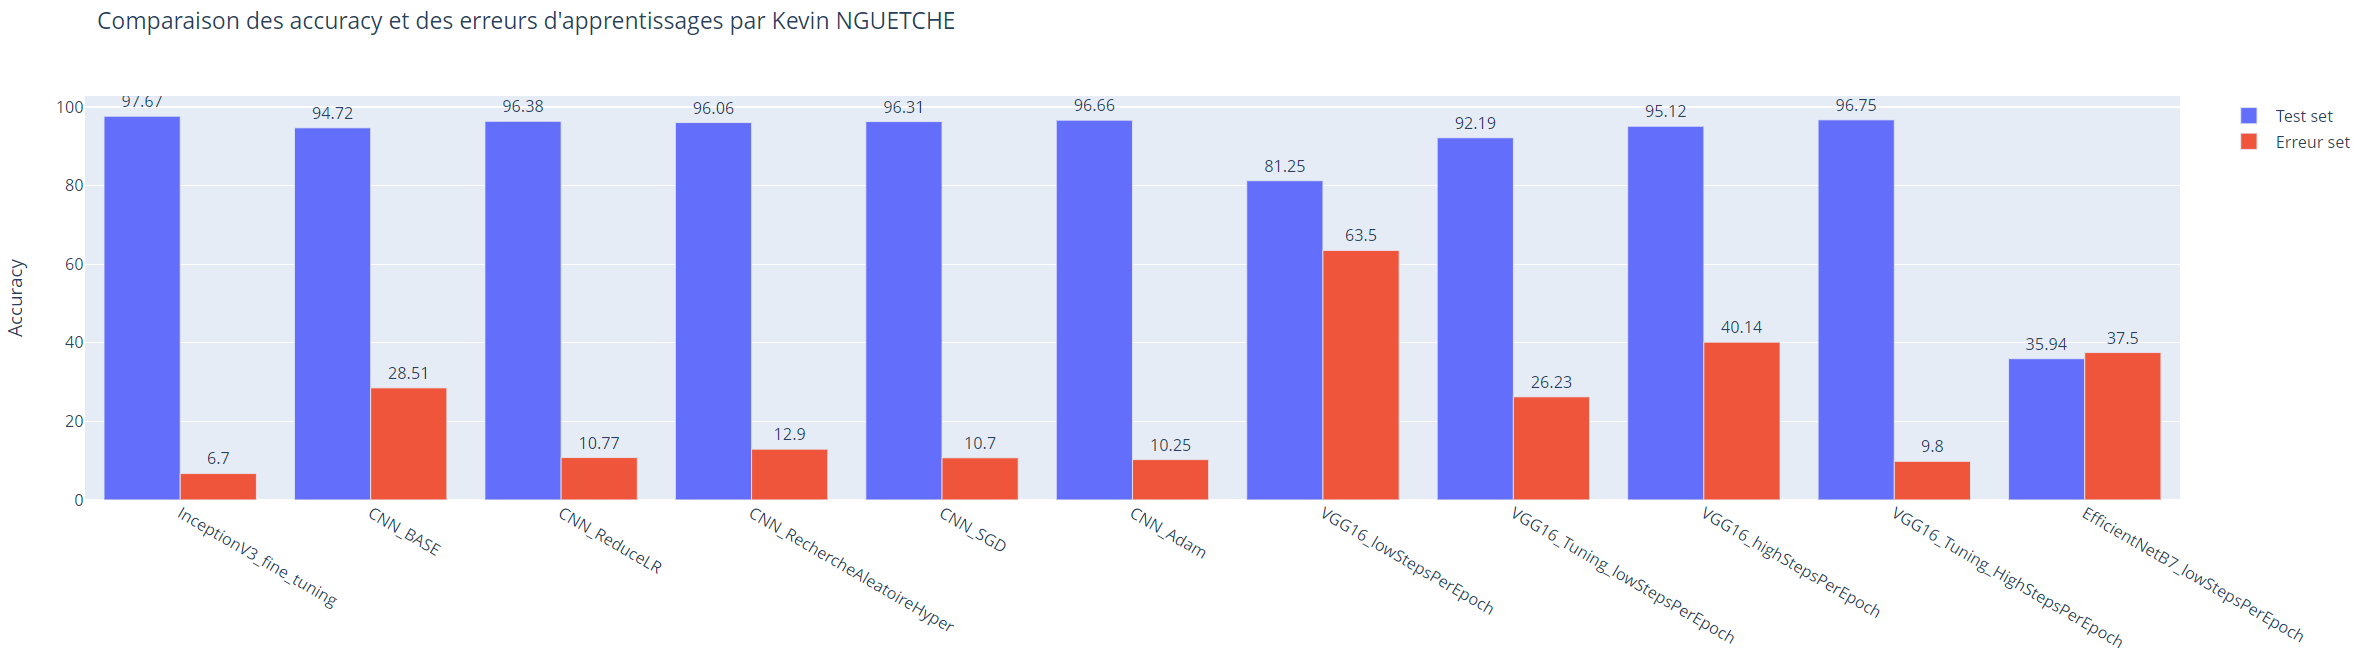

#Résultats détaillés
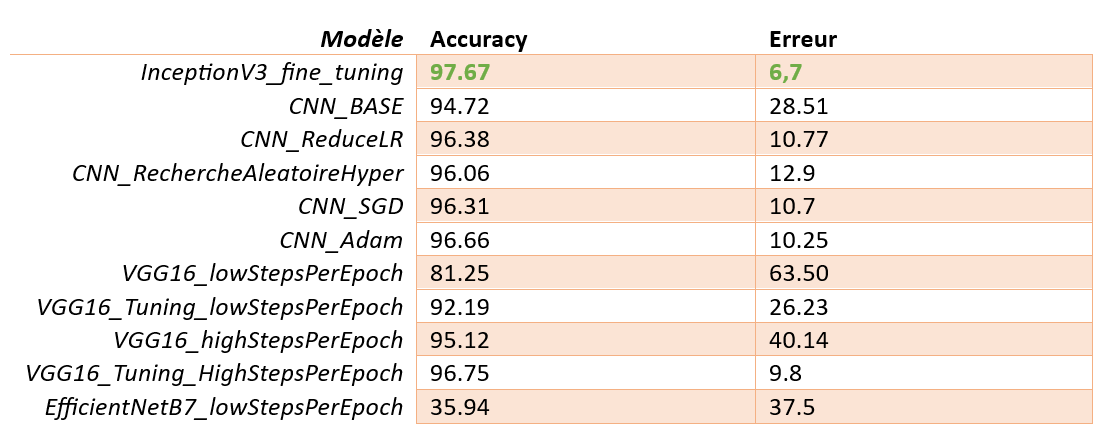

#Pourquoi notre choix s'est porté sur InceptionV3 pourtant il est moins performant que EfficientNetB7, NASNetLarge et Xception ?

La raison en est que ce modèle est plus rapide que les trois modèles cités plus haut, ce qui correspond parfaitement à la situation actuelle où google colab nous limite un temps d'utilisation journalier de son GPU. La rapidité de InceptionV3 s'explique par son utilisation des boîtes parallèles et réutilisables appelées inception afin de traiter les entrées à différent niveaux d'echelle spatiales. 

#Conclusion

De ce challenge, il en resort que le meilleur optimiseur sur les données quickdraw est **Adam**. Egalement, pour obtenir un niveau de performance plus élevé sur un modèle, en plus d'augmenter le nombre d'époques, l'on doit s'assurer que **steps_per_epoch=df_train_set.samples // df_train_set.batch_size** et
        **validation_steps=df_val_set.samples // df_val_set.batch_size.** Enfin, nous avons pû constater que tous les modèles pré-entrainés utilisés dans ce challenge permettent de fournir une performance de plus de 98% lorsqu'ils sont entrainés en fine tuning; Ceci demande juste des matériels de meilleur performances(GPU).

#Difficultés rencontrés

La principale difficulté que nous avons rencontré est celle liée au fait qu'il y a un temps d'utilisation journalier du GPU de google et ce temps est très faible pour supporter les entrainnements des modèles pré-entrainés en fine Tuning. Nous n'avons donc pas pû utiliser les modèles pré-entrés sur plus de 10 époques (En utilisant les hyper-paramètres optima), ce qui est très dommage car, à certaines époques notre modèle InceptionV3 obtenait prêt de 99% comme on peut le constater sur ses traces d'éxécutions. Egalement, dans la littérature il est prouvé que **EfficientNetB7**, **NASNetLarge** et **Xception**  surpasse de très loin les performances de InceptionV3 en terme de classification : à coup sûr, l'implémentation que nous avons fournit de ces modèles atteint plus de 98%.

#Dans les sections qui suivent, je vais décrire pas à pas le travail que j'ai réalisé

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Exam/Data_Train_Valid.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images/rabbit/rabbit_124616.png  
  inflating: __MACOSX/images/rabbit/._rabbit_124616.png  
  inflating: images/rabbit/rabbit_076144.png  
  inflating: __MACOSX/images/rabbit/._rabbit_076144.png  
  inflating: images/rabbit/rabbit_061438.png  
  inflating: __MACOSX/images/rabbit/._rabbit_061438.png  
  inflating: images/rabbit/rabbit_009790.png  
  inflating: __MACOSX/images/rabbit/._rabbit_009790.png  
  inflating: images/rabbit/rabbit_041930.png  
  inflating: __MACOSX/images/rabbit/._rabbit_041930.png  
  inflating: images/rabbit/rabbit_067049.png  
  inflating: __MACOSX/images/rabbit/._rabbit_067049.png  
  inflating: images/rabbit/rabbit_036560.png  
  inflating: __MACOSX/images/rabbit/._rabbit_036560.png  
  inflating: images/rabbit/rabbit_062109.png  
  inflating: __MACOSX/images/rabbit/._rabbit_062109.png  
  inflating: images/rabbit/rabbit_131545.png  
  inflating: __MACOSX/images/rabbit/._rabbit_131545.png  
  in

In [ ]:
import tensorflow
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# Ajouter les imports nécessaires
import os
import shutil
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow import keras


## Données

In [ ]:
# Repertoire parent
home_path = '/content'

In [ ]:
classes = ["basket","eye","binoculars","rabbit","hand"]
df_train = pd.read_csv('train.csv') # J'ai déjà x_train = df_train['image_name'] et y_train = df_train['class_label']
df_val = pd.read_csv('valid.csv') # J'ai déjà x_val = df_val['image_name'] et y_val = df_val['class_label']

print(df_train)

              image_name             relative_path  class_label
0      basket_052681.png  basket/basket_052681.png            0
1      basket_028248.png  basket/basket_028248.png            0
2      basket_050738.png  basket/basket_050738.png            0
3      basket_034414.png  basket/basket_034414.png            0
4      basket_091738.png  basket/basket_091738.png            0
...                  ...                       ...          ...
74995    hand_241467.png      hand/hand_241467.png            4
74996    hand_052619.png      hand/hand_052619.png            4
74997    hand_168727.png      hand/hand_168727.png            4
74998    hand_285523.png      hand/hand_285523.png            4
74999    hand_263562.png      hand/hand_263562.png            4

[75000 rows x 3 columns]


In [ ]:
df_train['class_label'] = df_train['class_label'].astype('str')
df_val['class_label'] = df_val['class_label'].astype('str')

#Augmentation des données

##Prémière méthode d'augmentation des données

Au vu de la structure de nos données (toutes les images dans un seul dossier), la technique rapide d'augmentation des données que nous pouvons l'appliquer est présenté dans le bloc de code ci-dessous.

In [ ]:
#Entrées
input_size = (28,28)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023,
                                              )

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023,
                                              )


Found 75000 validated image filenames belonging to 5 classes.
Found 25000 validated image filenames belonging to 5 classes.


Afin d'avoir une structure de données scalable, à la place d'utiliser le code précédant, nous pouvons diviser dans un prémier temps, nos images dans deux dossiers différents : Le dossier Train et le dossier Val. Par la suite, nous pouvons créer à l'intérieur des dossiers Train et Val, un sous repertoire associé à chaque classe. Les codes ci-dessous illustrent parfaitement cela : 

##Deuxième méthode d'augmentation des données

In [ ]:
# Création des repertoires de Train et de Val
train_path = os.path.join(home_path,'train')
os.mkdir(train_path)

val_path = os.path.join(home_path,'val')
os.mkdir(val_path)

In [ ]:
# Création des sous-repertoires pour les données de Train et de Val

#Train
basket_train_path = os.path.join(home_path + r'/train','basket')
os.mkdir(basket_train_path)

binoculars_train_path = os.path.join(home_path + r'/train','binoculars')
os.mkdir(binoculars_train_path)

eye_train_path = os.path.join(home_path + r'/train','eye')
os.mkdir(eye_train_path)

hand_train_path = os.path.join(home_path + r'/train','hand')
os.mkdir(hand_train_path)

rabbit_train_path = os.path.join(home_path + r'/train','rabbit')
os.mkdir(rabbit_train_path)

#val
basket_val_path = os.path.join(home_path + r'/val','basket')
os.mkdir(basket_val_path)

binoculars_val_path = os.path.join(home_path + r'/val','binoculars')
os.mkdir(binoculars_val_path)

eye_val_path = os.path.join(home_path + r'/val','eye')
os.mkdir(eye_val_path)

hand_val_path = os.path.join(home_path + r'/val','hand')
os.mkdir(hand_val_path)

rabbit_val_path = os.path.join(home_path + r'/val','rabbit')
os.mkdir(rabbit_val_path)

In [ ]:
#Copie des images d'entrainnement vers le dossier Train
df_train['class_label'] = df_train['class_label'].astype('int64')
df_val['class_label'] = df_val['class_label'].astype('int64')

for i in range(len(df_train)):

    image = df_train.loc[i,'image_name']

    if df_train.loc[i,'class_label'] == 0:
        shutil.copy(home_path + r'/images/basket/' + image, home_path + r'/train/basket/')
    elif df_train.loc[i,'class_label'] == 1 :
        shutil.copy(home_path + r'/images/eye/' + image, home_path + r'/train/eye/')
    elif df_train.loc[i,'class_label'] == 2 :
        shutil.copy(home_path + r'/images/binoculars/' + image, home_path + r'/train/binoculars/')
    elif df_train.loc[i,'class_label'] == 3 :
        shutil.copy(home_path + r'/images/rabbit/' + image, home_path + r'/train/rabbit/')
    elif df_train.loc[i,'class_label'] == 4 :
        shutil.copy(home_path + r'/images/hand/' + image, home_path + r'/train/hand/')
    else :
        continue

df_train['class_label'] = df_train['class_label'].astype('str')
df_val['class_label'] = df_val['class_label'].astype('str')

In [ ]:
#Copie des images de validation vers le dossier Val
df_train['class_label'] = df_train['class_label'].astype('int64')
df_val['class_label'] = df_val['class_label'].astype('int64')

for i in range(len(df_val)):

    image = df_val.loc[i,'image_name']

    if df_val.loc[i,'class_label'] == 0:
        shutil.copy(home_path + r'/images/basket/' + image, home_path + r'/val/basket/')
    elif df_val.loc[i,'class_label'] == 1 :
        shutil.copy(home_path + r'/images/eye/' + image, home_path + r'/val/eye/')
    elif df_val.loc[i,'class_label'] == 2 :
        shutil.copy(home_path + r'/images/binoculars/' + image, home_path + r'/val/binoculars/')
    elif df_val.loc[i,'class_label'] == 3 :
        shutil.copy(home_path + r'/images/rabbit/' + image, home_path + r'/val/rabbit/')
    elif df_val.loc[i,'class_label'] == 4 :
        shutil.copy(home_path + r'/images/hand/' + image, home_path + r'/val/hand/')
    else :
        continue

df_train['class_label'] = df_train['class_label'].astype('str')
df_val['class_label'] = df_val['class_label'].astype('str')

In [ ]:

train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=input_size,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        'val',
        target_size=input_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 75000 images belonging to 5 classes.
Found 25000 images belonging to 5 classes.


 Affichage des classes du dataset issu de la prémière méthode

In [ ]:
# Affichage des classes du dataset issu de la prémière méthode
df_train_set.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

On peut constater que la colonne 'class_indices' a bel et bien été transformée en string avant l'appel de la fonction : flow_from_dataframe

Affichage des classes du dataset issu de la deuxième méthode

In [ ]:
# Affichage des classes du dataset issu de la deuxième méthode
validation_generator.class_indices

{'basket': 0, 'binoculars': 1, 'eye': 2, 'hand': 3, 'rabbit': 4}

Maintenant que nos images ont été chargés. Affichons les.

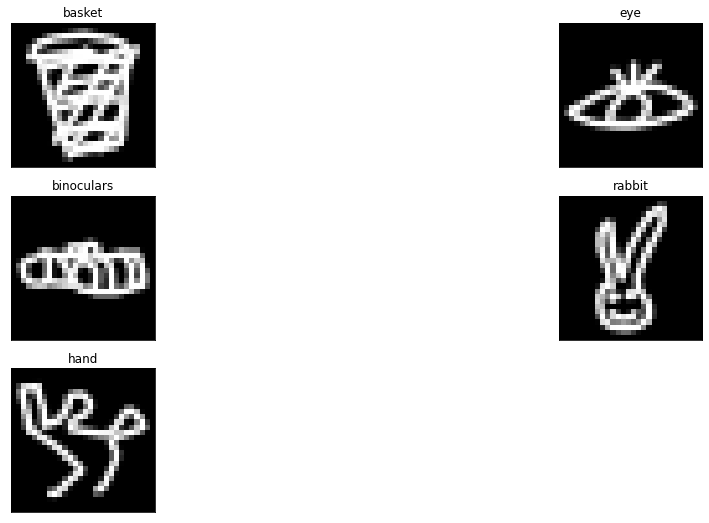

In [ ]:
# Affichage d'une image par classe à partir du dossier images

plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im,cmap='gray')
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

In [ ]:
from keras.optimizers import *
optim = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(
        df_train_set,
        steps_per_epoch=df_train_set.samples // df_train_set.batch_size,
        epochs=30,
        validation_data=df_val_set,
        validation_steps=df_val_set.samples // df_val_set.batch_size)


Epoch 1/30
2343/2343 [==============================] - 63s 27ms/step - loss: 0.1758 - accuracy: 0.9443 - val_loss: 0.2282 - val_accuracy: 0.9431
Epoch 2/30
2343/2343 [==============================] - 63s 27ms/step - loss: 0.1785 - accuracy: 0.9439 - val_loss: 0.2282 - val_accuracy: 0.9509
Epoch 3/30
2343/2343 [==============================] - 62s 27ms/step - loss: 0.1753 - accuracy: 0.9434 - val_loss: 0.2747 - val_accuracy: 0.9446
Epoch 4/30
2343/2343 [==============================] - 61s 26ms/step - loss: 0.1755 - accuracy: 0.9442 - val_loss: 0.2121 - val_accuracy: 0.9526
Epoch 5/30
2343/2343 [==============================] - 61s 26ms/step - loss: 0.1733 - accuracy: 0.9452 - val_loss: 0.2717 - val_accuracy: 0.9403
Epoch 6/30
2343/2343 [==============================] - 63s 27ms/step - loss: 0.1729 - accuracy: 0.9444 - val_loss: 0.2682 - val_accuracy: 0.9348
Epoch 7/30
2343/2343 [==============================] - 63s 27ms/step - loss: 0.1749 - accuracy: 0.9437 - val_loss: 0.2329 -

In [ ]:
model.save('model_1')
model.save_weights('poids_model_1')

In [ ]:
test_valid_loss_11, test_valid_accuracy_11 = model.evaluate(df_val_set)

782/782 [==============================] - 9s 11ms/step - loss: 0.2851 - accuracy: 0.9471


#Optimisation du CNN par ajout du nombre de couches et modification des hyper-paramètres

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(125, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(100, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(units=num_classes, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 125)       1250      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 125)      500       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 125)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 100)       112600    
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 100)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 100)     

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/50
2344/2344 [==============================] - 74s 29ms/step - loss: 0.3642 - accuracy: 0.8764 - val_loss: 0.2694 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 2/50
2344/2344 [==============================] - 69s 30ms/step - loss: 0.2210 - accuracy: 0.9271 - val_loss: 0.1811 - val_accuracy: 0.9417 - lr: 0.0010
Epoch 3/50
2344/2344 [==============================] - 72s 31ms/step - loss: 0.1925 - accuracy: 0.9363 - val_loss: 0.1777 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 4/50
2344/2344 [==============================] - 67s 29ms/step - loss: 0.1814 - accuracy: 0.9406 - val_loss: 0.1528 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 5/50
2344/2344 [==============================] - 66s 28ms/step - loss: 0.1700 - accuracy: 0.9432 - val_loss: 0.1479 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 6/50
2344/2344 [==============================] - 67s 28ms/step - loss: 0.1594 - accuracy: 0.9475 - val_loss: 0.2218 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 7/50
2344/2344 [========================

# Méthode de recherche aléatoire pour trouver les meilleurs hyper-paramètres du CNN

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(learning_rate=0.001, dropout_rate=0.2, activation='relu', filters=16, kernel_size=(3,3), pool_size=(2,2)):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filters=filters * 2, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))

    optimizer = Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.1, 0.2, 0.3],
    'activation': ['relu', 'tanh'],
    'filters': [16, 32, 64],
    'kernel_size': [(3,3), (5,5)],
    'pool_size': [(2,2), (3,3)]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=3)
random_search.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=50,
                  callbacks=[early_stop, reduce_lr],
                )

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Nouveau CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()

# première couche de convolution
model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

# deuxième couche de convolution
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

# troisième couche de convolution
model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

# couche de flatten
model.add(Flatten())

# couches fully connected
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(units=num_classes, activation="softmax"))




# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Entraîner le modèle
model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
2344/2344 [==============================] - 77s 31ms/step - loss: 0.4063 - accuracy: 0.8733 - val_loss: 0.2324 - val_accuracy: 0.9273
Epoch 2/10
2344/2344 [==============================] - 70s 30ms/step - loss: 0.2277 - accuracy: 0.9288 - val_loss: 0.1651 - val_accuracy: 0.9468
Epoch 3/10
2344/2344 [==============================] - 70s 30ms/step - loss: 0.1979 - accuracy: 0.9385 - val_loss: 0.1796 - val_accuracy: 0.9474
Epoch 4/10
2344/2344 [==============================] - 71s 30ms/step - loss: 0.1852 - accuracy: 0.9437 - val_loss: 0.1505 - val_accuracy: 0.9495
Epoch 5/10
2344/2344 [==============================] - 70s 30ms/step - loss: 0.1627 - accuracy: 0.9495 - val_loss: 0.1282 - val_accuracy: 0.9565
Epoch 6/10
2344/2344 [==============================] - 71s 30ms/step - loss: 0.1573 - accuracy: 0.9516 - val_loss: 0.1304 - val_accuracy: 0.9582
Epoch 7/10
2344/2344 [==============================] - 69s 30ms/step - loss: 0.1522 - accuracy: 0.9533 - val_loss: 0.1373 -

SGD Classifier

In [ ]:
from tensorflow import keras
optim = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(
        df_train_set,
        steps_per_epoch=df_train_set.samples // df_train_set.batch_size,
        epochs=30,
        validation_data=df_val_set,
        validation_steps=df_val_set.samples // df_val_set.batch_size)

Epoch 1/30
2343/2343 [==============================] - 73s 30ms/step - loss: 0.3789 - accuracy: 0.8721 - val_loss: 0.2127 - val_accuracy: 0.9288
Epoch 2/30
2343/2343 [==============================] - 63s 27ms/step - loss: 0.2303 - accuracy: 0.9230 - val_loss: 0.1874 - val_accuracy: 0.9411
Epoch 3/30
2343/2343 [==============================] - 62s 27ms/step - loss: 0.1988 - accuracy: 0.9336 - val_loss: 0.1597 - val_accuracy: 0.9456
Epoch 4/30
2343/2343 [==============================] - 65s 28ms/step - loss: 0.1792 - accuracy: 0.9410 - val_loss: 0.1331 - val_accuracy: 0.9544
Epoch 5/30
2343/2343 [==============================] - 64s 28ms/step - loss: 0.1703 - accuracy: 0.9433 - val_loss: 0.1356 - val_accuracy: 0.9543
Epoch 6/30
2343/2343 [==============================] - 62s 27ms/step - loss: 0.1643 - accuracy: 0.9456 - val_loss: 0.1450 - val_accuracy: 0.9530
Epoch 7/30
2343/2343 [==============================] - 66s 28ms/step - loss: 0.1551 - accuracy: 0.9487 - val_loss: 0.1262 -

In [ ]:
model.save('model_2')
model.save_weights('poids_model_2')

In [ ]:
test_valid_loss_12, test_valid_accuracy_12 = model.evaluate(df_val_set)

782/782 [==============================] - 8s 10ms/step - loss: 0.1072 - accuracy: 0.9630


##Avec l'optimiseur Adam

In [ ]:
from tensorflow import keras
optim = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(
        df_train_set,
        steps_per_epoch=df_train_set.samples // df_train_set.batch_size,
        epochs=30,
        validation_data=df_val_set,
        validation_steps=df_val_set.samples // df_val_set.batch_size)

Epoch 1/30
2343/2343 [==============================] - 72s 29ms/step - loss: 0.1031 - accuracy: 0.9651 - val_loss: 0.1082 - val_accuracy: 0.9636
Epoch 2/30
2343/2343 [==============================] - 67s 29ms/step - loss: 0.1021 - accuracy: 0.9649 - val_loss: 0.1108 - val_accuracy: 0.9629
Epoch 3/30
2343/2343 [==============================] - 65s 28ms/step - loss: 0.0996 - accuracy: 0.9653 - val_loss: 0.1082 - val_accuracy: 0.9637
Epoch 4/30
2343/2343 [==============================] - 64s 27ms/step - loss: 0.1002 - accuracy: 0.9657 - val_loss: 0.1023 - val_accuracy: 0.9653
Epoch 5/30
2343/2343 [==============================] - 63s 27ms/step - loss: 0.0983 - accuracy: 0.9663 - val_loss: 0.1044 - val_accuracy: 0.9649
Epoch 6/30
2343/2343 [==============================] - 66s 28ms/step - loss: 0.0978 - accuracy: 0.9662 - val_loss: 0.1037 - val_accuracy: 0.9657
Epoch 7/30
2343/2343 [==============================] - 68s 29ms/step - loss: 0.0977 - accuracy: 0.9663 - val_loss: 0.1089 -

In [ ]:
model.save('model_3')
model.save_weights('poids_model_3')

In [ ]:
test_valid_loss_13, test_valid_accuracy_13 = model.evaluate(df_val_set)

782/782 [==============================] - 9s 11ms/step - loss: 0.1025 - accuracy: 0.9666


#Utilisation des modèles pré-entrainés

In [ ]:
from glob import glob
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model, Model

In [ ]:
IMG_SHAPE = (224, 224,3)

##VGG16

In [ ]:
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Entrées
input_size = (224,224)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

Found 75000 validated image filenames belonging to 5 classes.
Found 25000 validated image filenames belonging to 5 classes.


In [ ]:
model.fit(df_train_set, steps_per_epoch=12, validation_data=df_val_set, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 253s 22s/step - loss: 1.6240 - accuracy: 0.4141 - val_loss: 0.9555 - val_accuracy: 0.6641
Epoch 2/20
12/12 [==============================] - 259s 22s/step - loss: 0.9643 - accuracy: 0.6510 - val_loss: 0.9749 - val_accuracy: 0.7031
Epoch 3/20
12/12 [==============================] - 252s 22s/step - loss: 0.6889 - accuracy: 0.7682 - val_loss: 0.8054 - val_accuracy: 0.7422
Epoch 4/20
12/12 [==============================] - 252s 22s/step - loss: 0.5691 - accuracy: 0.8073 - val_loss: 0.4840 - val_accuracy: 0.8594
Epoch 5/20
12/12 [==============================] - 252s 22s/step - loss: 0.5739 - accuracy: 0.8073 - val_loss: 0.7783 - val_accuracy: 0.7422
Epoch 6/20
12/12 [==============================] - 251s 21s/step - loss: 0.6413 - accuracy: 0.8151 - val_loss: 0.7656 - val_accuracy: 0.7266
Epoch 7/20
12/12 [==============================] - 251s 21s/step - loss: 0.4823 - accuracy: 0.8672 - val_loss: 0.7733 - val_accuracy: 0.7344
Epoch 

## Fine tuning de VGG16

In [ ]:
base_model.trainable = True

In [ ]:
optim = keras.optimizers.Adam(learning_rate=.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(df_train_set, steps_per_epoch=12, validation_data=df_val_set, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 750s 62s/step - loss: 0.3999 - accuracy: 0.8828 - val_loss: 0.3026 - val_accuracy: 0.8828
Epoch 2/10
12/12 [==============================] - 673s 57s/step - loss: 0.3489 - accuracy: 0.8880 - val_loss: 0.5495 - val_accuracy: 0.8047
Epoch 3/10
12/12 [==============================] - 708s 59s/step - loss: 0.2560 - accuracy: 0.9141 - val_loss: 0.3305 - val_accuracy: 0.8750
Epoch 4/10
12/12 [==============================] - 668s 56s/step - loss: 0.2562 - accuracy: 0.9193 - val_loss: 0.3115 - val_accuracy: 0.8828
Epoch 5/10
12/12 [==============================] - 649s 55s/step - loss: 0.2881 - accuracy: 0.9141 - val_loss: 0.4338 - val_accuracy: 0.8516
Epoch 6/10
12/12 [==============================] - 727s 60s/step - loss: 0.3043 - accuracy: 0.8906 - val_loss: 0.4349 - val_accuracy: 0.8516
Epoch 7/10
12/12 [==============================] - 669s 56s/step - loss: 0.2699 - accuracy: 0.9167 - val_loss: 0.2456 - val_accuracy: 0.8984
Epoch 

##VGG16 avec steps_per_epoch = df_train_set.samples // df_train_set.batch_size 

In [ ]:
model.fit(df_train_set,validation_data=df_val_set,epochs=10)

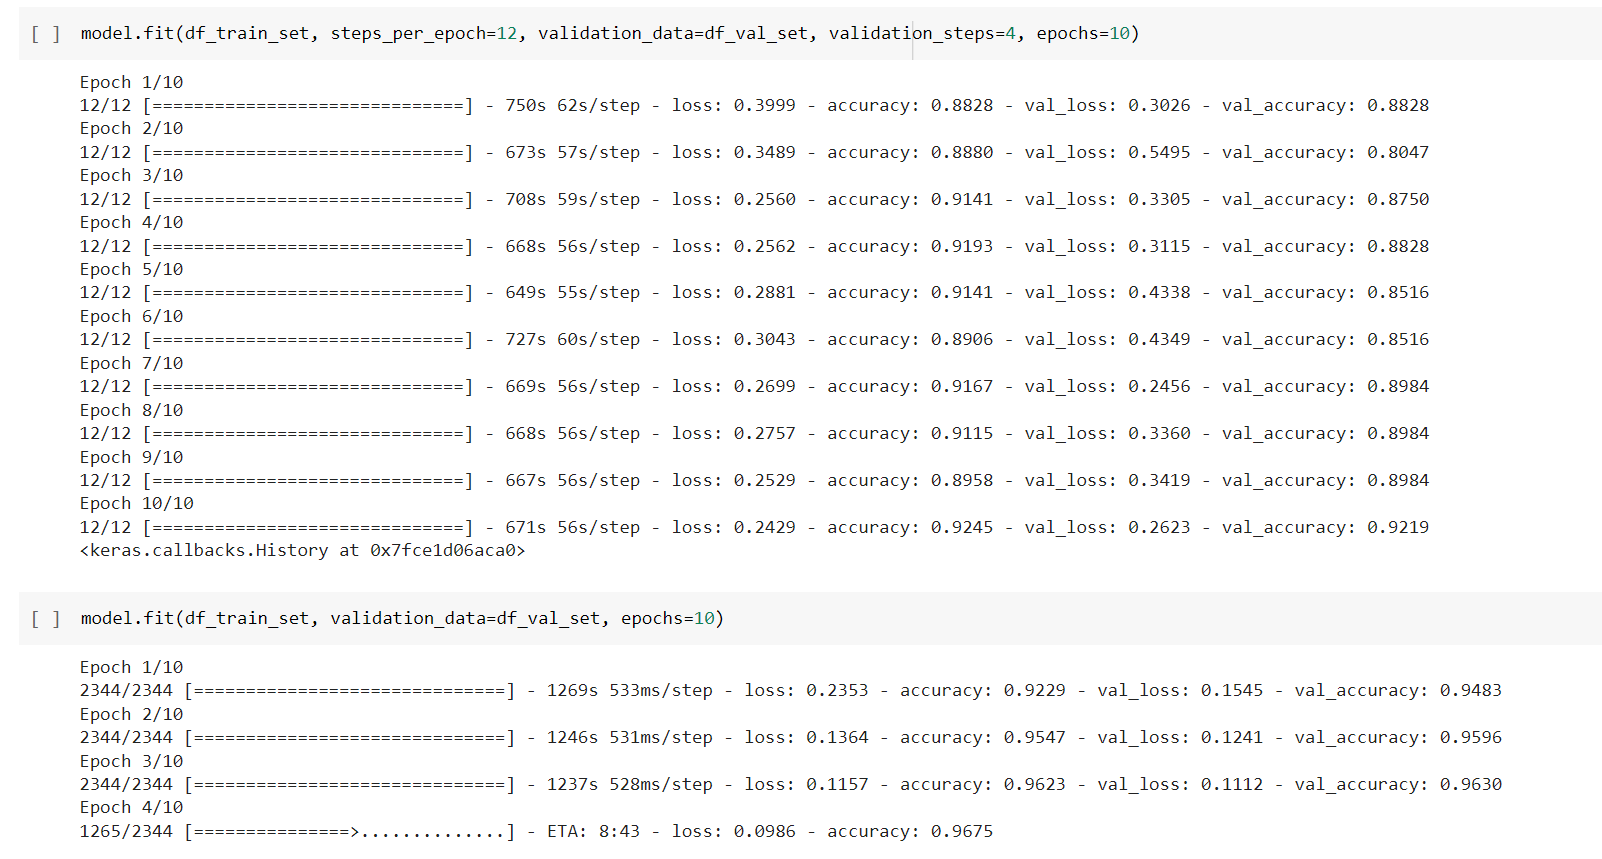

In [ ]:
model.save('model_4')
model.save_weights('poids_model_4')

In [ ]:
test_valid_loss_14, test_valid_accuracy_14 = model.evaluate(df_val_set)

##EfficientNetB7

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [ ]:
IMG_SHAPE = (600, 600,3)

In [ ]:
base_model = EfficientNetB7(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 600, 600, 3)  0           ['normalization[0][0

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 19, 19, 2560) dtype=float32 (created by layer 'top_activation')>

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 600, 600, 3)  0           ['normalization[0][0]']    

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Entrées
input_size = (600,600)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

Found 75000 validated image filenames belonging to 5 classes.
Found 25000 validated image filenames belonging to 5 classes.


In [ ]:
model.fit(df_train_set,steps_per_epoch=4,validation_data=df_val_set, epochs=50,validation_steps=4) # steps_per_epoch=12, , validation_steps=4

Epoch 1/50
4/4 [==============================] - 110s 9s/step - loss: 209.5080 - accuracy: 0.1797 - val_loss: 405.2611 - val_accuracy: 0.2266
Epoch 2/50
4/4 [==============================] - 36s 10s/step - loss: 297.1653 - accuracy: 0.1953 - val_loss: 190.1091 - val_accuracy: 0.2422
Epoch 3/50
4/4 [==============================] - 27s 7s/step - loss: 174.9730 - accuracy: 0.1953 - val_loss: 284.0010 - val_accuracy: 0.2109
Epoch 4/50
4/4 [==============================] - 36s 10s/step - loss: 205.0021 - accuracy: 0.2188 - val_loss: 109.6043 - val_accuracy: 0.1719
Epoch 5/50
4/4 [==============================] - 27s 7s/step - loss: 115.4711 - accuracy: 0.1875 - val_loss: 177.3282 - val_accuracy: 0.1562
Epoch 6/50
4/4 [==============================] - 36s 10s/step - loss: 135.3217 - accuracy: 0.1797 - val_loss: 122.8448 - val_accuracy: 0.1719
Epoch 7/50
4/4 [==============================] - 36s 10s/step - loss: 90.5332 - accuracy: 0.1641 - val_loss: 93.9650 - val_accuracy: 0.2266
Epo

##Fine Tunning EfficientNetB7

In [ ]:
base_model.trainable = True

In [ ]:
optim = keras.optimizers.Adam(learning_rate=.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(df_train_set,validation_data=df_val_set, epochs=10)  #steps_per_epoch=12, validation_steps=4, 

In [ ]:
model.save('model_5')
model.save_weights('poids_model_5')

In [ ]:
test_valid_loss_15, test_valid_accuracy_15 = model.evaluate(df_val_set)

##NASNetLarge

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge

In [ ]:
IMG_SHAPE = (331, 331,3)

In [ ]:
base_model = NASNetLarge(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

343610240/343610240 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Entrées
input_size = (331,331)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=5)

##Fine Tuning NASNetLarge

In [ ]:
base_model.trainable = True

In [ ]:
optim = keras.optimizers.Adam(learning_rate=.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=5)

In [ ]:
model.save('model_6')
model.save_weights('poids_model_6')

In [ ]:
test_valid_loss_16, test_valid_accuracy_16 = model.evaluate(df_val_set)

##InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
IMG_SHAPE = (299, 299,3)

In [ ]:
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                      

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'mixed10')>

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Entrées
input_size = (299,299)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

Found 75000 validated image filenames belonging to 5 classes.
Found 25000 validated image filenames belonging to 5 classes.


In [ ]:
model.fit(df_train_set, steps_per_epoch=12, validation_data=df_val_set, validation_steps=4, epochs=10)

## Fine Tuning InceptionV3

In [ ]:
base_model.trainable = True

In [ ]:
optim = keras.optimizers.Adam(learning_rate=.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=10)

Epoch 1/10
2344/2344 [==============================] - 1886s 804ms/step - loss: 0.2812 - accuracy: 0.9063 - val_loss: 0.0962 - val_accuracy: 0.9688
Epoch 2/10
2344/2344 [==============================] - 1887s 805ms/step - loss: 0.1554 - accuracy: 0.9486 - val_loss: 0.1644 - val_accuracy: 0.9609
Epoch 3/10
2344/2344 [==============================] - 1854s 791ms/step - loss: 0.1214 - accuracy: 0.9596 - val_loss: 0.2019 - val_accuracy: 0.9375
Epoch 4/10
2344/2344 [==============================] - 1842s 786ms/step - loss: 0.1043 - accuracy: 0.9649 - val_loss: 0.2113 - val_accuracy: 0.9453
Epoch 5/10
2344/2344 [==============================] - 1818s 775ms/step - loss: 0.0896 - accuracy: 0.9696 - val_loss: 0.0412 - val_accuracy: 0.9844
Epoch 6/10
2344/2344 [==============================] - 1825s 778ms/step - loss: 0.0776 - accuracy: 0.9726 - val_loss: 0.1353 - val_accuracy: 0.9609
Epoch 7/10
1960/2344 [========================>.....] - ETA: 5:00 - loss: 0.0676 - accuracy: 0.9767

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=10)

Epoch 1/10
2344/2344 [==============================] - 2024s 847ms/step - loss: 0.3121 - accuracy: 0.8944 - val_loss: 0.1546 - val_accuracy: 0.9502
Epoch 2/10
2344/2344 [==============================] - 1917s 818ms/step - loss: 0.1570 - accuracy: 0.9479 - val_loss: 0.1305 - val_accuracy: 0.9573
Epoch 3/10
2344/2344 [==============================] - 1916s 817ms/step - loss: 0.1244 - accuracy: 0.9586 - val_loss: 0.1206 - val_accuracy: 0.9578
Epoch 4/10
2344/2344 [==============================] - 1928s 822ms/step - loss: 0.1030 - accuracy: 0.9655 - val_loss: 0.1018 - val_accuracy: 0.9667
Epoch 5/10
2344/2344 [==============================] - 1910s 815ms/step - loss: 0.0892 - accuracy: 0.9694 - val_loss: 0.0939 - val_accuracy: 0.9681
Epoch 6/10
 844/2344 [=========>....................] - ETA: 19:34 - loss: 0.0752 - accuracy: 0.9735

In [ ]:
model.save('model_7')
model.save_weights('poids_model_7')

In [ ]:
test_valid_loss_17, test_valid_accuracy_17 = model.evaluate(df_val_set)

##Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
IMG_SHAPE = (299, 299,3)

In [ ]:
base_model = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 10, 10, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Entrées
input_size = (299,299)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

Found 75000 validated image filenames belonging to 5 classes.
Found 25000 validated image filenames belonging to 5 classes.


In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=5)

##Fine Tunning Xception

In [ ]:
base_model.trainable = True

In [ ]:
optim = keras.optimizers.Adam(learning_rate=.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=10)

In [ ]:
model.save('model_8')
model.save_weights('poids_model_8')

In [ ]:
test_valid_loss_17, test_valid_accuracy_17 = model.evaluate(df_val_set)

##ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
IMG_SHAPE = (224, 224,3)

In [ ]:
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
base_model.summary()

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

In [ ]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Entrées
input_size = (224,224)
batch_size = 32
num_classes = 5
#Augmentation des données
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)


df_train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

df_val_set = val_datagen.flow_from_dataframe(dataframe=df_val, 
                                              directory=home_path+'/images/',
                                              x_col="relative_path", 
                                              y_col="class_label", 
                                              class_mode="categorical", 
                                              target_size=input_size, 
                                              batch_size=batch_size,
                                              rescale=1.0/255,
                                              seed=2023)

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=5)

##Fine Tuning ResNet50

In [ ]:
base_model.trainable = True

In [ ]:
optim = keras.optimizers.Adam(learning_rate=.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(df_train_set, validation_data=df_val_set, epochs=5)

In [ ]:
model.save('model_9')
model.save_weights('poids_model_9')

In [ ]:
test_valid_loss_9, test_valid_accuracy_9 = model.evaluate(df_val_set)

##CNN avec 15 couches de convolutions

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(375, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(350, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(325, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(300, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(275, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(250, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(225, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(200, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(175, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(150, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(125, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(100, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))


model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(units=num_classes, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 375)       3750      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 375)      1500      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 375)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 350)       1181600   
                                                                 
 dropout (Dropout)           (None, 14, 14, 350)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 350)      1

In [ ]:
from tensorflow import keras
optim = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
model.fit(
        df_train_set,
        steps_per_epoch=df_train_set.samples // df_train_set.batch_size,
        epochs=30,
        validation_data=df_val_set,
        validation_steps=df_val_set.samples // df_val_set.batch_size)

Epoch 1/30
2343/2343 [==============================] - 136s 49ms/step - loss: 1.1923 - accuracy: 0.4988 - val_loss: 0.6108 - val_accuracy: 0.7839
Epoch 2/30
2343/2343 [==============================] - 104s 44ms/step - loss: 0.5630 - accuracy: 0.8275 - val_loss: 0.3861 - val_accuracy: 0.8838
Epoch 3/30
2343/2343 [==============================] - 102s 44ms/step - loss: 0.4124 - accuracy: 0.8751 - val_loss: 0.5175 - val_accuracy: 0.8485
Epoch 4/30
2343/2343 [==============================] - 104s 44ms/step - loss: 0.3323 - accuracy: 0.9012 - val_loss: 0.2063 - val_accuracy: 0.9349
Epoch 5/30
2343/2343 [==============================] - 103s 44ms/step - loss: 0.2790 - accuracy: 0.9168 - val_loss: 0.2144 - val_accuracy: 0.9336
Epoch 6/30
2343/2343 [==============================] - 103s 44ms/step - loss: 0.2519 - accuracy: 0.9235 - val_loss: 0.2028 - val_accuracy: 0.9402
Epoch 7/30
2343/2343 [==============================] - 103s 44ms/step - loss: 0.2236 - accuracy: 0.9314 - val_loss: 0

In [ ]:
model.save('model_10')
model.save_weights('poids_model_10')

In [ ]:
test_valid_loss_10, test_valid_accuracy_10 = model.evaluate(df_val_set)

782/782 [==============================] - 13s 16ms/step - loss: 0.1077 - accuracy: 0.9651


#Comparaison des différents modèles

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Comparaison de nos modèles
acc_combine = {'Model':  ['InceptionV3_fine_tuning', 'CNN_BASE', 'CNN_ReduceLR', 'CNN_RechercheAleatoireHyper','CNN_SGD', 'CNN_Adam', 'VGG16_lowStepsPerEpoch','VGG16_Tuning_lowStepsPerEpoch','VGG16_highStepsPerEpoch', 'VGG16_Tuning_HighStepsPerEpoch','EfficientNetB7_lowStepsPerEpoch'],
        'Accuracy_Test': [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11],
        'Erreur_Test': [e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11]
        }


In [ ]:
# Schéma de comparaison
import numpy as np

fig = go.Figure(data=[
    go.Bar(name='Test set', x=acc_combine['Model'], y=acc_combine['Accuracy_Test'],text=np.round(acc_combine['Accuracy_Test'],2),textposition='outside'),
    go.Bar(name='Erreur set', x=acc_combine['Model'], y=acc_combine['Erreur_Test'],text=np.round(acc_combine['Erreur_Test'],2),textposition='outside')
])

fig.update_layout(barmode='group',title_text='Comparaison des accuracy et des erreurs d\'apprentissages par Kevin NGUETCHE',yaxis=dict(
        title='Accuracy'))
fig.show()